In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import os
import csv

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, cross_val_predict
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.gridspec as gridspec

from deforestutils import *

from joblib import dump, load
from joblib import Parallel, delayed




/Users/annieulichney/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Set to create new indices for test train split and cross validation
Starting fit for 2004
Files setup.
Read in data for 2004
Years in data: [2004 2005 2006 2007]
Number of rows in data: (665048, 216)
Test set pct of data: 30.0
New test/train indices generated and saved in TestTrainSplit


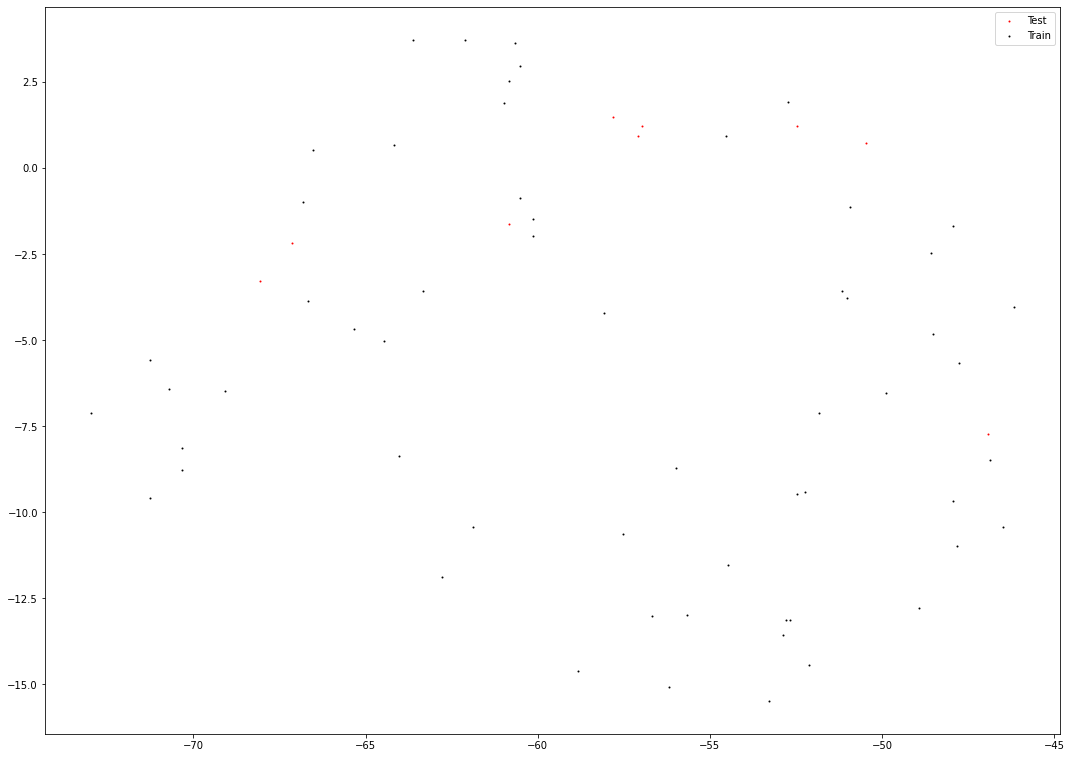

New cross validation indices generated and read in
randomforest MSE: 0.0004379221427356267


invalid value encountered in true_divide


lasso MSE: 0.0003769778542047435
gradientboosting MSE: 0.00045317891245449043


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature

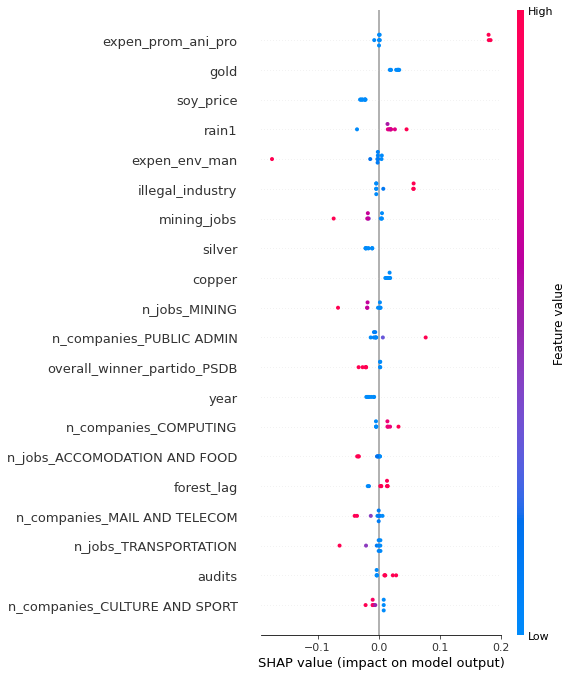

neuralnetwork MSE: 0.019557898796346656


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-02, tolerance: 6.883e-06
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-02, tolerance: 5.257e-06
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.205e-03, tolerance: 7.327e-06
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.578e-02, tolerance: 7.696e-06
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-02, tolerance: 6.027e-06


Meta Data Shape:  (58, 4) (58,)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e-02, tolerance: 8.320e-06
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


RandomForestRegressor: 0.000
Lasso: 1.046
GradientBoostingRegressor: 0.000
MLPRegressor: 0.004
MSE: 0.00030971904417371527


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with

superlearner MSE: 0.00030971904417371527


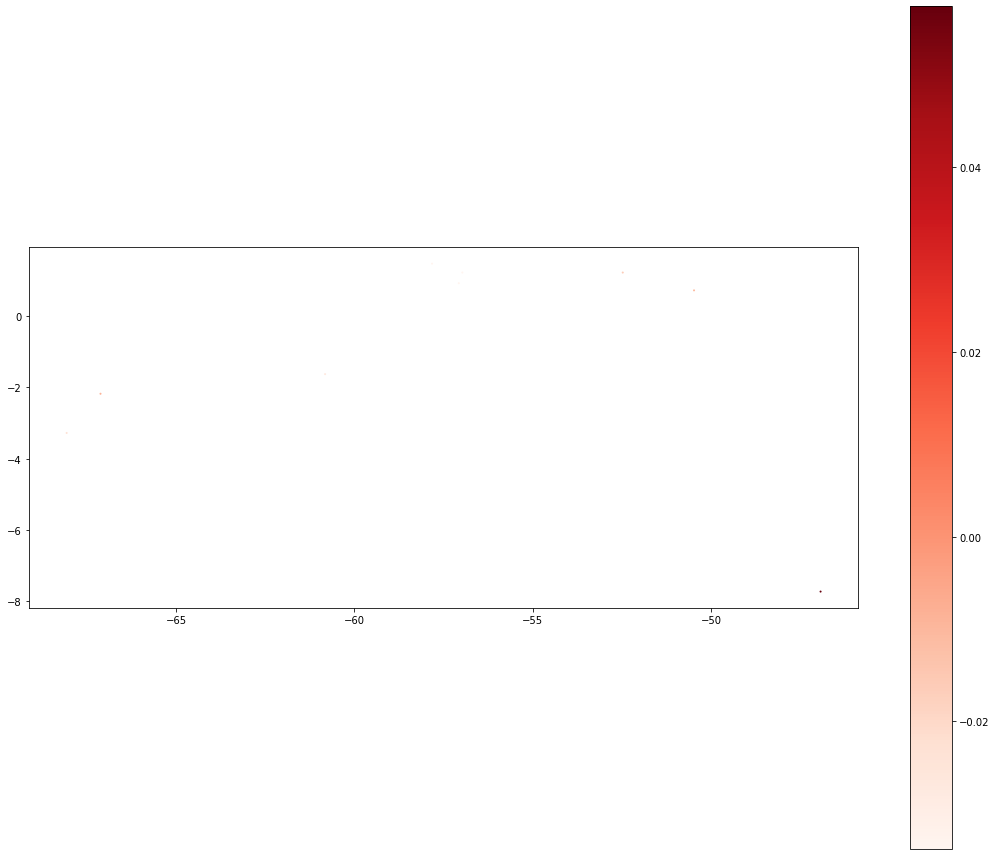

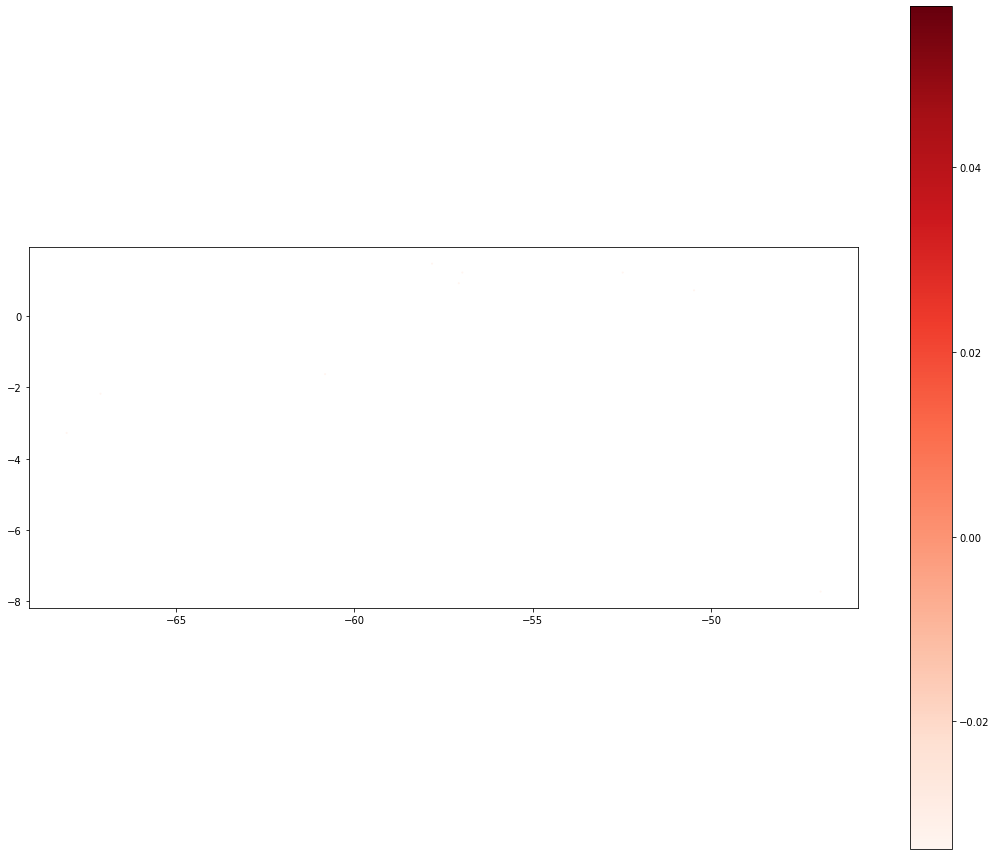

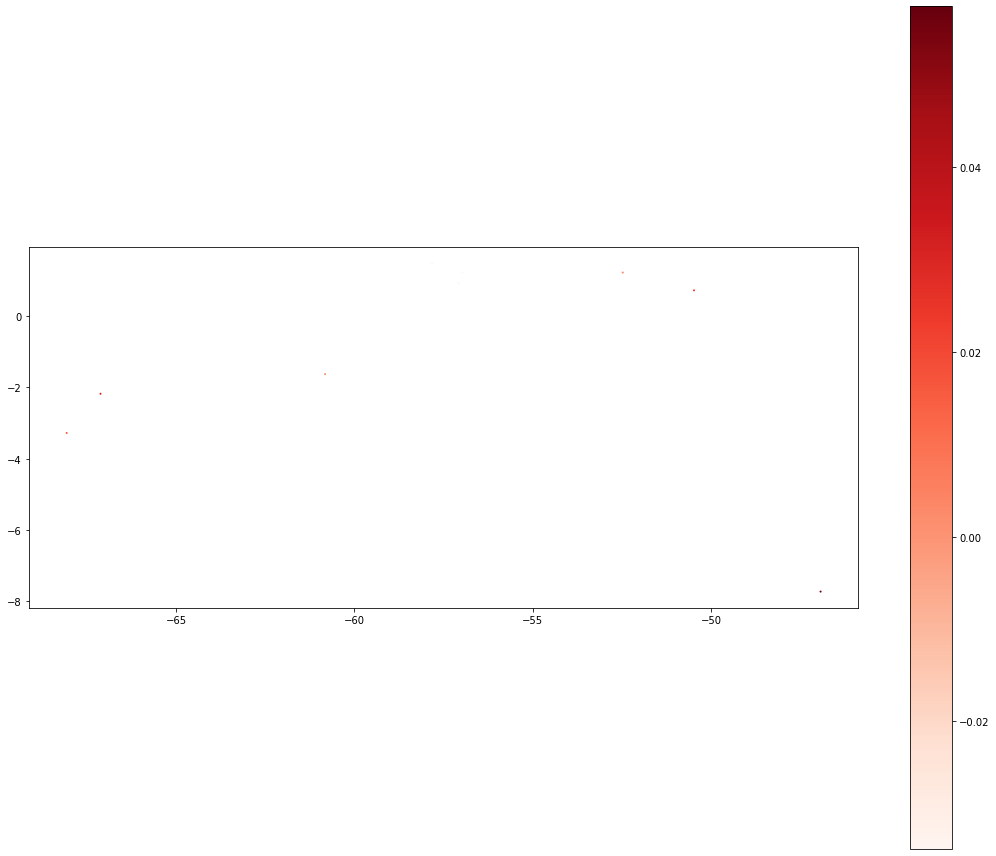

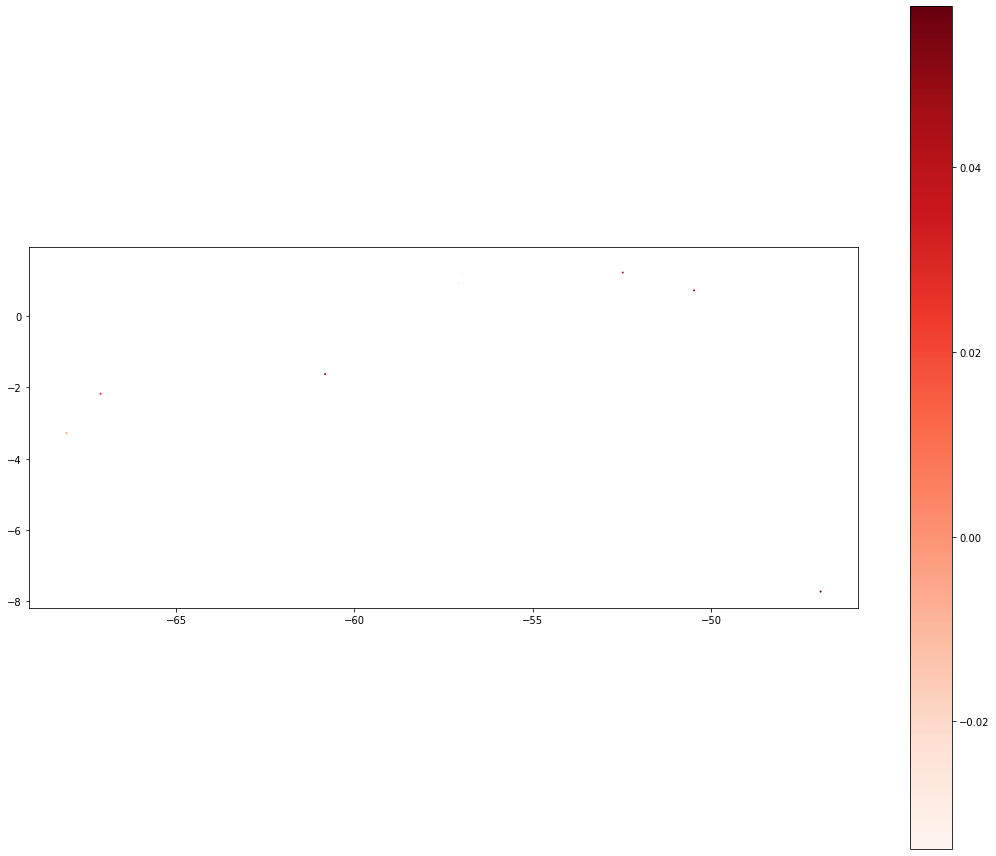

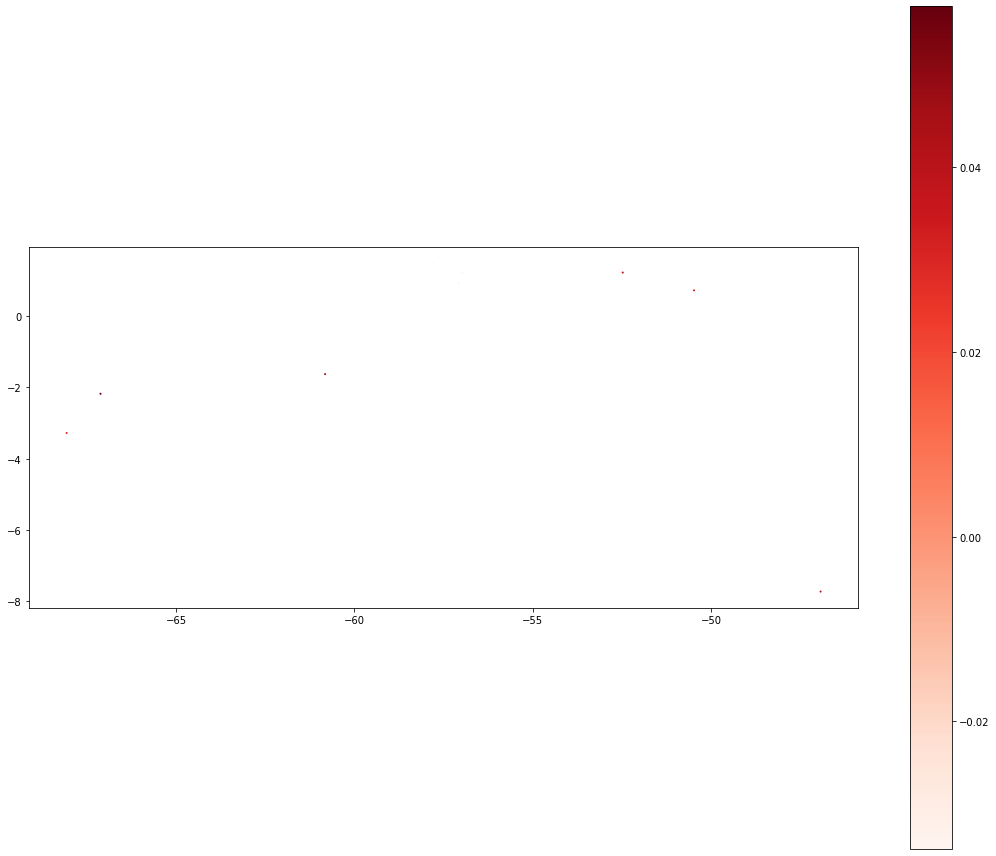

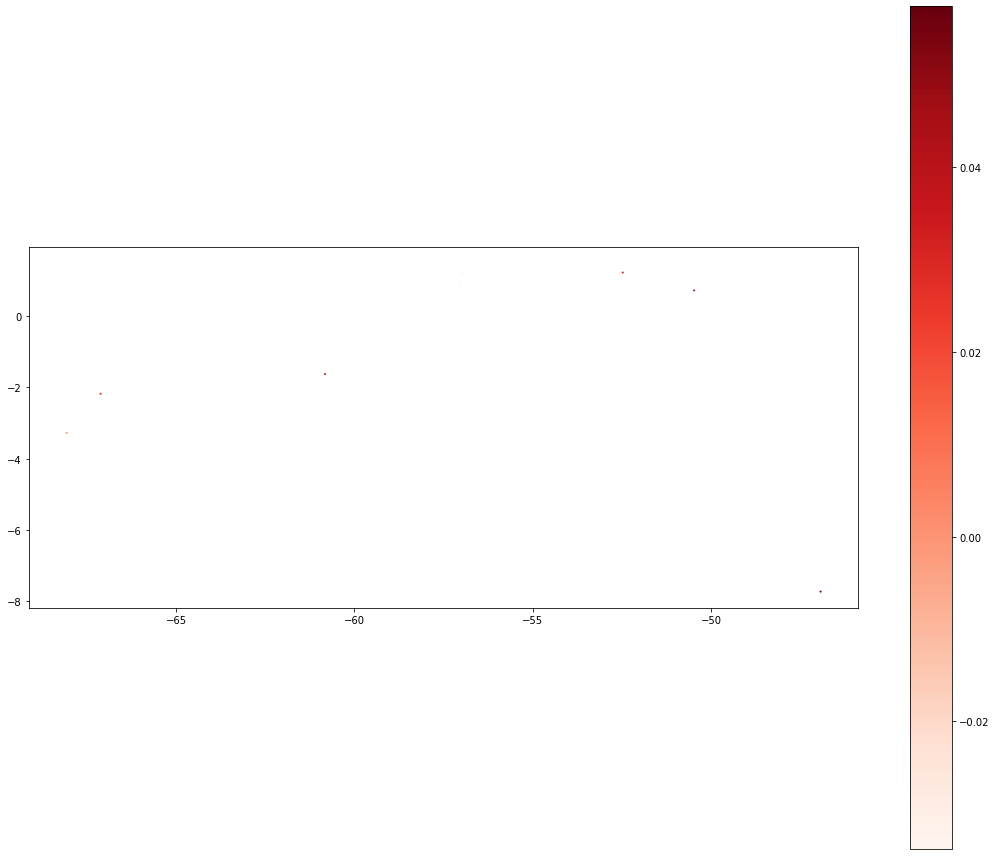

100%|██████████| 1/1 [01:37<00:00, 97.35s/it]


In [3]:
first_time = True

for this_start_year in tqdm([2004]):
    SUBSET = True
    SUBSET_SIZE = 100

    if first_time: 
        NEW_INDICES = True
        NEW_CV_INDICES = True
        first_time = False
        print('Set to create new indices for test train split and cross validation')
    else: 
        NEW_INDICES = False
        NEW_CV_INDICES = False
        print('Reading previous iteration test train split indices and cross validation indices')
    

    PLOT_ENTIRE_AREA = True
    PLOT_FOLDS = False

    START_YEAR_TRAIN = this_start_year
    NUMBER_YEARS_TRAIN = 3
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + i  for i in range(NUMBER_YEARS_TRAIN + 1)]

    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN

    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + i}_' for i in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'

    FILE_PATH = f'FeatureImportanceResults/{FOLDER_NAME}/'

    print(f'Starting fit for {this_start_year}')

    setup_directory(FOLDER_NAME)
    
    df_full = get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN)
    
    if SUBSET:
        df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)

    X, Y = split_XY(df_full)

    if NEW_INDICES:
        train_inds, test_inds = get_new_test_train_inds(X, Y, df_full, FOLDER_NAME)
    if not NEW_INDICES:
        train_inds, test_inds = get_prev_test_train_inds(FOLDER_NAME)

    X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME)

    if NEW_CV_INDICES:
        muni_cv = get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR, FILE_PATH)
    if not NEW_CV_INDICES:
        muni_cv = get_prev_cv(FOLDER_NAME)

    get_null_count(X_train, FOLDER_NAME)
            
    X_train = X_train.drop('geometry', axis = 1)
    X_test = X_test.drop('geometry', axis = 1)

    #random forest
    randomforest_features_df = train_random_forest(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME)

    #lasso 
    lasso_features_df = train_lasso(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME)

    #gradient boosting
    gradient_boosting_features_df = train_gradient_boost(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME)
    
    #neural network
    nn_features_df = train_neural_network(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME)

    #super learner ensemble
    base_learners = get_base_learners(FOLDER_NAME, FOLDER_NAME)
    super_learner_features_df = train_super_learner(X_train, Y_train, X_test, Y_test, FILE_PATH, muni_cv, base_learners, FOLDER_NAME)

    #visualize
    yhat_list = get_yhat_list(FOLDER_NAME)
    visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)
    